# Deep Agent - Multi-Agent Deep Finance Researcher

Advanced financial research system using LangChain's DeepAgent with context isolation and strategic delegation.

## Overview

This notebook demonstrates:
- **DeepAgent Framework**: LangChain's advanced agent architecture
- **Context Isolation**: Sub-agents with isolated contexts for focused research
- **Strategic Delegation**: Orchestrator coordinates multiple specialist sub-agents
- **RAG + Live Data**: Hybrid search on SEC filings + Yahoo Finance integration
- **File-Based Memory**: Persistent research artifacts with secure sandbox (virtual_mode=True)

**Key Features:**
1. Orchestrator breaks down complex queries into research tasks
2. Sub-agents conduct focused research with isolated context
3. Think tool for strategic reflection and decision-making
4. Final report synthesis with consolidated citations
5. SQLite checkpointer for conversation memory
6. FilesystemBackend with virtual_mode for secure file operations

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import os
import uuid
import sqlite3
from datetime import datetime
from IPython.display import Image, display

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.messages import HumanMessage, AIMessage, ToolMessage
from deepagents import create_deep_agent
from deepagents.backends import FilesystemBackend
from deepagents.backends.utils import file_data_to_string
from langgraph.checkpoint.sqlite import SqliteSaver

from scripts.rag_tools import hybrid_search, live_finance_researcher, think_tool
from scripts.prompts import (
    DEEP_RESEARCHER_INSTRUCTIONS,
    DEEP_RESEARCH_WORKFLOW_INSTRUCTIONS,
    DEEP_SUBAGENT_DELEGATION_INSTRUCTIONS
)

## Initialize Memory and File Backend

In [4]:
# SQLite checkpointer for agent memory
conn = sqlite3.connect('data/deep_agent_finance_researcher.db', check_same_thread=False)
checkpointer = SqliteSaver(conn=conn)

# Secure filesystem backend for research outputs
RESEARCH_OUTPUT_DIR = os.path.join(os.getcwd(),"research_outputs")
os.makedirs(RESEARCH_OUTPUT_DIR, exist_ok=True)

print(f"Writing research files to: {RESEARCH_OUTPUT_DIR}")

# Create filesystem backend with virtual_mode=True for security
# This sandboxes all file operations to RESEARCH_OUTPUT_DIR only
backend = FilesystemBackend(
    root_dir=RESEARCH_OUTPUT_DIR,
    virtual_mode=True  # Prevents agent from accessing files outside sandbox
)

Writing research files to: d:\Courses\Udemy\Multi Agent Deep RAG\research_outputs


## Create Research Sub-Agent

In [5]:
# Get current date
current_date = datetime.now().strftime("%Y-%m-%d")

# Create research sub-agent with isolated context
research_sub_agent = {
    "name": "financial-research-agent",
    "description": "Delegate financial research to this sub-agent. Give it one specific research task at a time.",
    "system_prompt": DEEP_RESEARCHER_INSTRUCTIONS.format(date=current_date),
    "tools": [hybrid_search, live_finance_researcher, think_tool],
}

## Initialize LLM and Create DeepAgent

In [6]:
# Initialize model
model = ChatGoogleGenerativeAI(model='gemini-3-flash-preview')

# Limits for sub-agent delegation
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Combine orchestrator instructions
INSTRUCTIONS = (
    DEEP_RESEARCH_WORKFLOW_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + DEEP_SUBAGENT_DELEGATION_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
    )
)

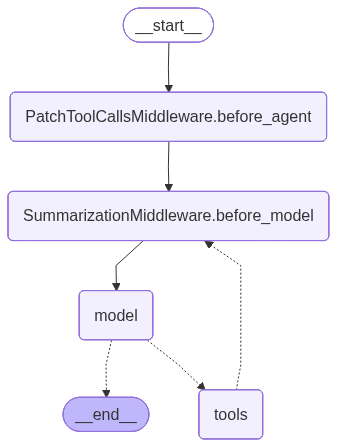

In [9]:
# Tools for the main agent (orchestrator level)
tools = [hybrid_search, live_finance_researcher, think_tool]

# Create the deep agent with memory and secure file backend
agent = create_deep_agent(
    model=model,
    tools=tools,
    system_prompt=INSTRUCTIONS,
    subagents=[research_sub_agent],
    checkpointer=checkpointer,  # SQLite memory
    backend=backend,  # Secure filesystem with virtual_mode=True
)

# Visualize the agent graph
agent

## Streaming Helper Function

In [11]:
def stream_deep_agent(agent, query):
    """
    Stream deep agent responses with tool call visibility.
    
    Args:
        agent: The deep agent instance
        query: User query string
    
    Returns:
        Result dictionary with messages and files
    """
    # Generate unique thread_id for each invocation
    thread_id = str(uuid.uuid4())
    config = {'configurable': {'thread_id': thread_id}}
    
    print(f"\n{'='*60}")
    print(f"Query: {query}")
    print(f"Thread ID: {thread_id}")
    print(f"{'='*60}\n")
    
    # Invoke agent
    result = agent.invoke(
        {'messages': [HumanMessage(query)]},
        config=config
    )
    
    # Display final report if available
    if '/final_report.md' in result.get('files', {}):
        report = file_data_to_string(result['files']['/final_report.md'])
        print(f"\n{'='*60}")
        print("FINAL REPORT")
        print(f"{'='*60}\n")
        print(report)
    else:
        print("\nNo final report generated")
    
    print(f"\n{'='*60}\n")
    
    return result

## Example 1: Simple Financial Query

In [12]:
query = "What was Amazon's revenue in Q1 2024?"
result = stream_deep_agent(agent, query)
result


Query: What was Amazon's revenue in Q1 2024?
Thread ID: 7934c3d2-b90e-4165-be4b-b39f36be99e2


No final report generated




{'messages': [HumanMessage(content="What was Amazon's revenue in Q1 2024?", additional_kwargs={}, response_metadata={}, id='8473ebea-2664-49c2-9cde-0eabfb85990a'),
  AIMessage(content=[], additional_kwargs={'function_call': {'name': 'write_file', 'arguments': '{"file_path": "/research_request.md", "content": "What was Amazon\'s revenue in Q1 2024?"}'}, '__gemini_function_call_thought_signatures__': {'a5327441-3010-44e9-bbe2-24f79920e48e': 'EocFCoQFAXLI2ny5FPz3MdTTagL0cHprkdl24lH8ZY5ErogBfXs3hL7s8YcMU/WmBYp0GYPibO7fPISqynqzkpXo1R8H32uY72MTGAyJlxB9pxhHJoavTmPuUfdrYwVJom9M1p5VSQt7Kcxircy18Bk1QPAQ1VmPr4zdFeQ9mXVgw2YZ7K4F/XO5e8SrY6zI4+ieoi2iM3H0SbMzivmafy+t5w/+9pE5AP34C6++P1Rx3ZVzCHt+W7zZJy8Dl+OYkPY7XPRUc6iP6Y8d5W/UzzXOzzclF8wySRyAsD6CHAo0S+VzvWAVcFy85ogKbTWdTr8Eu9Bzq+K4ju0yA2B+qDl/ba7v4zRgxR9p7GY+KJftAutyvf5fYIdQ75kGfr948KTOOyte8tTqv/HCQLt4JLxumIYOYWKpX8NjrF/vdyEW1XNoZL9ocxPklEywbSGeGYpWAMLa+zAa3q5gr8rI5ZU9+zUGbnIa12+R0+eIfbOCm4kf+tMRjzdUOFQQvR4YR94WhOPWlPsgUIU5Cq0kxInuc8aWHluGZwHYttdbgqDM

In [ ]:
# Files are already displayed by stream_deep_agent helper
# The final report is printed automatically if available

In [ ]:
query = "Compare Apple and Amazon's 2024 revenue and profitability. Present full and detailed report."
result = stream_deep_agent(agent, query)

In [ ]:
# Files are already displayed by stream_deep_agent helper
# The final report is printed automatically if available

In [ ]:
query = "Compare Apple and Microsoft's Q1 2024 revenue and profitability"
result = stream_deep_agent(agent, query)

## Example 3: Complex Financial Analysis

In [ ]:
# Files are already displayed by stream_deep_agent helper
# The final report is printed automatically if available

## Example 4: Historical + Live Data

In [ ]:
query = "Research Meta's 2024 annual financial performance from SEC filings and compare it with current stock performance"
result = stream_deep_agent(agent, query)

## Example 4: Historical + Live Data

In [ ]:
query = "Research Google's Q2 2024 financial performance from SEC filings and compare it with current stock performance"
result = stream_deep_agent(agent, query)

## Inspect Generated Files

In [ ]:
# List all files generated
print("Generated Files:")
for file_path in result.get('files', {}).keys():
    print(f"  - {file_path}")

In [ ]:
query = "Analyze Tesla's financial performance in 2023 and 2024, including revenue, profitability, and cash flow trends"
result = stream_deep_agent(agent, query)